#### Description
Binary classification test on the data for a first glance. Trying simple classifiers, discovering measurement techniques.

All read file variables (like train.csv, embeddings files etc) are set to relative path, which means just drag the competition files in to the program's folder and it reads in them automatically. 
Furthermore, I turned off the support for AMD Radeon GPUs, turn it on if necessary (for quicker computing on Radeon machines).

In [33]:
# support for AMD Radeon GPU - if you run this on AMD Radeon GPU computer, then use it

# import plaidml.keras
# plaidml.keras.install_backend()
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


# keras layers, tokenizer, model, sequential etc.
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, SimpleRNN, RNN, LSTM, GRU, Embedding, Dropout, Activation, Flatten, Conv1D, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow as tf
# time for idle the system after deleting models and embedding to test in one notebook
import time
# linear algebra
import numpy as np 
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 
# monitor loading time where it is supported
from tqdm import tqdm
import math

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib. pyplot as plt
import gc

random_seed = 63445


In [32]:
# train_df = pd.read_csv("/Users/sneakysneak/Downloads/quora_dataset/train.csv")
# test_df = pd.read_csv("/Users/sneakysneak/Downloads/quora_dataset/test.csv")]
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [3]:
# Split the training dataset into train and val sample. 
# Cross validation is a time consuming process and so 
# let us do simple train val split.

## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

## configuration values 
embed_size = 300 # the size of each word vector
max_features = 50000 # the size of unique words in use - the number of rows in the embedding vector
maxlen = 100 # the size of the number of words in each question

## first fill all missing values up
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## tokenize with Keras
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

test_X = tokenizer.texts_to_sequences(test_X)

## sentence padding
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## save the target values as train_y and val_y
train_y = train_df['target'].values
val_y = val_df['target'].values

In [4]:
train_X.shape

(1175509, 100)

In [5]:
train_y.shape

(1175509,)

In [6]:
target_count = train_df.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0: 1102824
Class 1: 72685
Proportion: 15.17 : 1


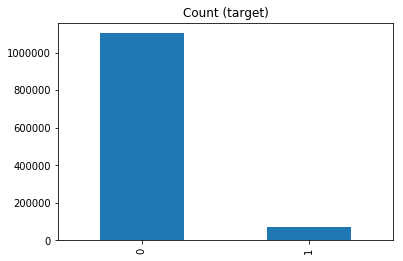

In [7]:
target_count.plot(kind='bar', title='Count (target)');

In [8]:
some_digit = train_X[0]
y_train_1 = (train_y == 1)
y_test_1 = (val_y == 1)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_X, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
val_y[0]

0

In [11]:
sgd_clf.predict([some_digit])

array([False])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=2, random_state=42)

for train_index, test_index in skfolds.split(train_X, y_train_1):
    clone_clf = clone(sgd_clf)
    X_train_folds = train_X[train_index]
    y_train_folds = train_y[train_index]
    X_test_folds = train_X[test_index]
    y_test_folds = y_train_1[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

/Users/sneakysneak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9252443620215907
0.8502723928718477


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_X, y_train_1, cv=2, scoring="accuracy")

array([0.92524436, 0.85027239])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, train_X, y_train_1, cv=2, scoring="accuracy")

array([0.93809325, 0.93824117])

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, train_X, y_train_1, cv=2)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_1, y_train_pred)

array([[1038702,   64122],
       [  67819,    4866]])

In [18]:
y_train_perfect_predictions = y_train_1 # pretend reaached perfection
confusion_matrix(y_train_1, y_train_perfect_predictions)

array([[1102824,       0],
       [      0,   72685]])

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_1, y_train_pred)

0.07053400591407201

In [20]:
recall_score(y_train_1, y_train_pred)

0.0669464126023251

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_1, y_train_pred)

0.06869339958919483

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-31618.49988858])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, train_X, y_train_1, cv=2, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

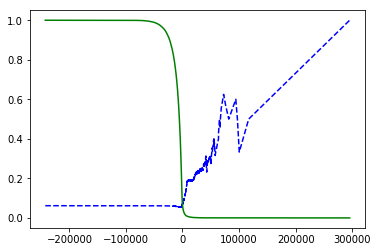

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")

    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    [...] # highlight the threshold, add the legend, axis label and grid 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()


In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # 7816

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
# Let’s check these predictions’ precision and recall:
precision_score(y_train_1, y_train_pred_90)

1.0

In [31]:
recall_score(y_train_1, y_train_pred_90)

1.3757996835660727e-05